In [1]:
%load_ext autoreload
%autoreload 2

# === Standard Libraries ===
import os
import sys
import random
import json
from typing import Any

# === Scientific Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

# === Signal Processing ===
import scipy
from scipy import signal
from scipy.signal import butter, filtfilt, correlate

# === Seismology Libraries ===
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

# === Machine Learning Libraries ===
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

# === PyTorch ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# === File Handling ===
import h5py

# === Custom Modules ===
module_path = os.path.abspath(os.path.join('../scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.model_selection import train_test_split
from neural_network_architectures import (
     QuakeXNet_1d, QuakeXNet_2d, SeismicCNN_1d, SeismicCNN_2d )


# === Seismology Client ===
client = Client('IRIS')

from utils import extract_waveforms
from utils import compute_spectrogram
from utils import normalize_spectrogram_minmax
from utils import return_train_val_loaders
from utils import plot_confusion_matrix_and_cr
from utils import train_model
from utils import WaveformPreprocessor


from collections import defaultdict
import json

import seisbench.models as sbm

cuda


## Loading the trained models

In [2]:
# ====================
# 1. Model Setup Parameters
# ====================
# Fixed parameters for the models (do not change)
num_channels = 3        # Number of input channels (seismic data)
dropout = 0.9           # Dropout rate to prevent overfitting

# Set device to GPU if available, else use CPU
device = "cuda"     #torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 2. Model Initialization
# ============================
# Initialize models with the number of classes, channels, and dropout rate
model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_1d = QuakeXNet_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_2d = QuakeXNet_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)

# ============================
# 3. Load Pretrained Weights
# ============================
# Load the pretrained model state dictionaries from saved files
saved_model_seismiccnn_2d = torch.load('../trained_models/best_model_new_augmented_SeismicCNN_2d.pth', map_location=device)
saved_model_quakexnet_2d = torch.load('../trained_models/best_model_new_augmented_QuakeXNet_2d.pth', map_location=device)
saved_model_quakexnet_1d = torch.load('../trained_models/best_model_new_augmented_QuakeXNet_1d.pth', map_location=device)
saved_model_seismiccnn_1d = torch.load('../trained_models/best_model_new_augmented_SeismicCNN_1d.pth', map_location=device)

# ============================
# 4. Load Weights into Models
# ============================
# Load the state dictionaries into the corresponding models
model_seismiccnn_1d.load_state_dict(saved_model_seismiccnn_1d)
model_seismiccnn_2d.load_state_dict(saved_model_seismiccnn_2d)
model_quakexnet_1d.load_state_dict(saved_model_quakexnet_1d)
model_quakexnet_2d.load_state_dict(saved_model_quakexnet_2d)


# ============================
# 5. Set Models to Evaluation Mode
# ============================
# Move models to evaluation mode (important for layers like dropout and batch norm)
model_seismiccnn_1d.eval()
model_seismiccnn_2d.eval()
model_quakexnet_1d.eval()
model_quakexnet_2d.eval()

# ============================
# 6. Move Models to Correct Device
# ============================
# Ensure all models are on the correct device (GPU or CPU)
model_seismiccnn_1d.to(device)
model_seismiccnn_2d.to(device)
model_quakexnet_1d.to(device)
model_quakexnet_2d.to(device)

/tmp/ipykernel_995963/3388980850.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model_seismiccnn_2d = torch.load('../trained_models/best_model_new_augmented_Seis

QuakeXNet_2d(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): Bat

In [24]:
# Inference config
device = 'cuda'
model = model_seismiccnn_2d
model.to(device)
model.eval()

# Storage
stn_probs_new = []

starttime = obspy.UTCDateTime("2021-08-02T04:14:28.000000Z")
stream = client.get_waveforms(network = "UW", station="RCM", channel="HH?", location="",
                         starttime=starttime-600, endtime=starttime+600)

# Constants
sample_rate = 50
num_samples = 5000
n_channels = 3
window_alpha = 0.1
lowcut = 1   # define these
highcut = 20
fs = 50

stride = 70 * fs


# Resample to 50 Hz
stream.resample(sample_rate)

data = np.array(stream)
        
        
processor = WaveformPreprocessor(input_fs = 50, target_fs = 50, lowcut = 1, highcut = 20, order = 4, taper_alpha = 0.1)

for  i in range(0,data.shape[-1], stride):

    try:
            
        waveform_np = data[:,i:i+5000]  # (C, T) as NumPy array
        waveform_tensor = torch.tensor(waveform_np, dtype=torch.float32)  # Convert to PyTorch tensor
        processed = processor(waveform_tensor)  # Calls your WaveformPreprocessor
        processed = processed.unsqueeze(0)  # Add batch dimension if needed
        spec_local = compute_spectrogram(processed, 50)
        inputs = normalize_spectrogram_minmax(spec_local[0])

        
        with torch.no_grad():
            outputs = model(inputs.to('cuda'))
            probs = torch.nn.functional.softmax(outputs, dim=1)

        # Store results
        stn_probs_new.append(probs.cpu())

    except Exception as e:
        print(f"Failed to process event")
        continue

Failed to process event
Failed to process event


In [25]:
# --- ecosystem B: list of tensors ------------------------------------------
probs_a = torch.vstack([p.squeeze(0) for p in stn_probs_new]).numpy() 

In [26]:
# arg-max labels (0-3)
labels_a = probs_a.argmax(axis=1)

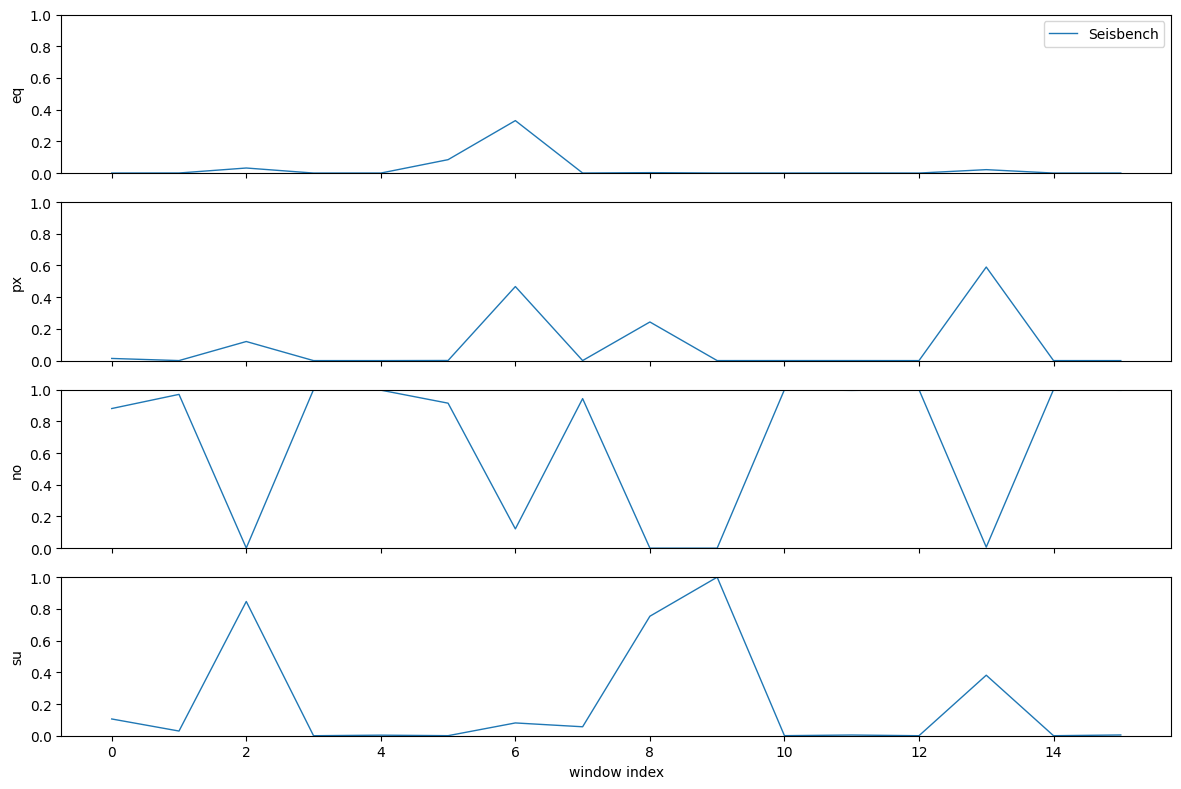

In [27]:
import matplotlib.pyplot as plt

time = np.arange(len(probs_a))    # one tick per window
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(12, 8))

class_names = ["eq", "px", "no", "su"]
for k in range(4):
    ax[k].plot(time, probs_a[:, k], label="Seisbench", lw=1)
    #ax[k].plot(time, probs_b[:, k], label="Local", lw=1, ls="--")
    ax[k].set_ylabel(class_names[k])
    ax[k].set_ylim(0, 1)
ax[-1].set_xlabel("window index")
ax[0].legend(loc="upper right")
plt.tight_layout()
plt.show()


/tmp/ipykernel_995963/1639770727.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


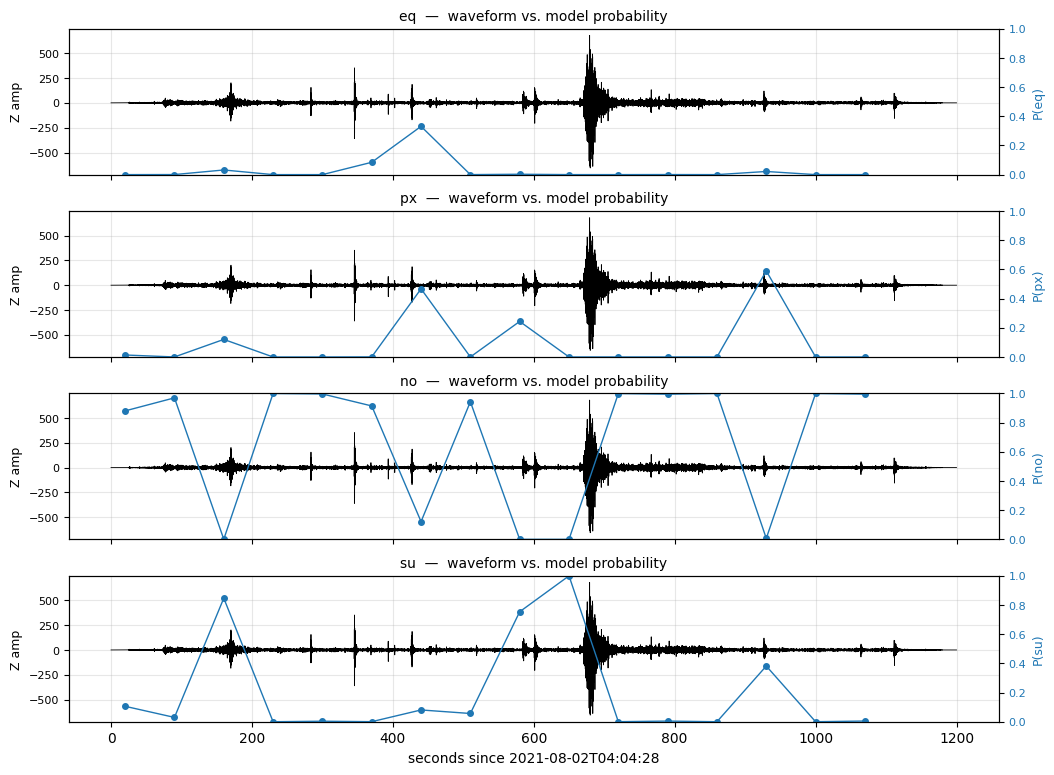

In [28]:
# ------------------------------------------------------------------
# 1 ▪  Download waveform and prep Z component
# ------------------------------------------------------------------
starttime = obspy.UTCDateTime("2021-08-02T04:14:28Z")
stream = client.get_waveforms(network="UW", station="RCM",
                              channel="HH?", location="",
                              starttime=starttime - 600,
                              endtime=starttime + 600)

stream.detrend('linear')
stream.taper(0.1)
stream.filter('bandpass', freqmin = 1, freqmax  = 10)
st_z  = stream.select(component="Z")[0]
sr    = st_z.stats.sampling_rate            # e.g., 100 Hz
z     = st_z.data.astype(float)
t_z   = np.arange(len(z)) / sr              # seconds since start

# ------------------------------------------------------------------
# 2 ▪  Build x-axis for probability windows
# ------------------------------------------------------------------
window_len = 5_000     # 100 s @ 50 Hz  (edit to match your model)
hop        = stride    # 20 s  @ 50 Hz
fs_model   = 50

t_prob = (np.arange(len(probs_a)) * hop) / fs_model   # seconds

class_names = ["eq", "px", "no", "su"]
prob_color  = "C0"   # blue
wave_color  = "k"    # black

# ------------------------------------------------------------------
# 3 ▪  Plot: one subplot per class
# ------------------------------------------------------------------
fig, axes = plt.subplots(4, 1, figsize=(12, 9),
                         sharex=True,
                         gridspec_kw={"hspace": 0.25})

for idx, cls in enumerate(class_names):
    ax_wave = axes[idx]                     # left axis: waveform
    ax_prob = ax_wave.twinx()               # right axis: probabilities

    # --- waveform -------------------------------------------------
    ax_wave.plot(t_z, z, color=wave_color, lw=0.6)
    ax_wave.set_ylabel("Z amp", color=wave_color, fontsize=9)
    ax_wave.tick_params(axis="y", labelcolor=wave_color, labelsize=8)

    # --- probability curve ---------------------------------------
    ax_prob.plot(t_prob+20, probs_a[:, idx], color=prob_color,
                 marker="o", markersize=4, lw=1,
                 label=f"P({cls})")
    ax_prob.set_ylim(0, 1)
    ax_prob.set_ylabel(f"P({cls})", color=prob_color, fontsize=9)
    ax_prob.tick_params(axis="y", labelcolor=prob_color, labelsize=8)

    # subtle grid for alignment
    ax_wave.grid(alpha=0.3)
    ax_wave.set_title(f"{cls}  —  waveform vs. model probability", fontsize=10)

# Common X-label
axes[-1].set_xlabel("seconds since {}".format(st_z.stats.starttime.isoformat()))

plt.tight_layout()
plt.show()
